<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Deep%20Convolutional%20Neural%20Networks/DenseNet/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  LeNet

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

In [2]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

### Reading Data

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

### Conv Block

In [4]:
def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

### Dense Block

In [5]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super().__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = np.concatenate((X, Y), axis=1)
        return X

In [6]:
X = np.random.uniform(size=(4, 3, 8, 8))

In [7]:
blk1 = DenseBlock(2, 10)
blk1.initialize()
blk1.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (4, 3, 8, 8)               0
         BatchNorm-1                                (4, 3, 8, 8)              12
        Activation-2                                (4, 3, 8, 8)               0
            Conv2D-3                               (4, 10, 8, 8)             280
         BatchNorm-4                               (4, 13, 8, 8)              52
        Activation-5                               (4, 13, 8, 8)               0
            Conv2D-6                               (4, 10, 8, 8)            1180
        DenseBlock-7                               (4, 23, 8, 8)               0
Parameters in forward computation graph, duplicate included
   Total params: 1524
   Trainable params: 1492
   Non-trainable params: 32
Shared params in forward computation graph: 0
Unique p

###  Transition Block

In [8]:
def transition_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

In [9]:
blk2 = transition_block(10)
blk2.initialize()
blk2.summary(blk1(X))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                               (4, 23, 8, 8)               0
         BatchNorm-1                               (4, 23, 8, 8)              92
        Activation-2                               (4, 23, 8, 8)               0
            Conv2D-3                               (4, 10, 8, 8)             240
         AvgPool2D-4                               (4, 10, 4, 4)               0
Parameters in forward computation graph, duplicate included
   Total params: 332
   Trainable params: 286
   Non-trainable params: 46
Shared params in forward computation graph: 0
Unique parameters in model: 332
--------------------------------------------------------------------------------


### Dense Net Model

In [10]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [11]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        num_channels //= 2
        net.add(transition_block(num_channels))

In [12]:
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))

In [13]:
net.initialize()

In [14]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 96, 96)               0
            Conv2D-1                             (1, 64, 48, 48)            3200
         BatchNorm-2                             (1, 64, 48, 48)             256
        Activation-3                             (1, 64, 48, 48)               0
         MaxPool2D-4                             (1, 64, 24, 24)               0
         BatchNorm-5                             (1, 64, 24, 24)             256
        Activation-6                             (1, 64, 24, 24)               0
            Conv2D-7                             (1, 32, 24, 24)           18464
         BatchNorm-8                             (1, 96, 24, 24)             384
        Activation-9                             (1, 96, 24, 24)               0
           Conv2D-10        

In [15]:
X = np.random.uniform(size=(1, 1, 96, 96))
for layer in net:
    print(layer.summary(X))
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 96, 96)               0
            Conv2D-1                             (1, 64, 48, 48)            3200
Parameters in forward computation graph, duplicate included
   Total params: 3200
   Trainable params: 3200
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 3200
--------------------------------------------------------------------------------
None
conv3 output shape:	 (1, 64, 48, 48)
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (1, 64, 48, 48)               0
         BatchNorm-1                             (1, 64, 48, 48)             256
Parameters in f

### Training

loss 0.146, train acc 0.946, test acc 0.893
1842.7 examples/sec on gpu(0)


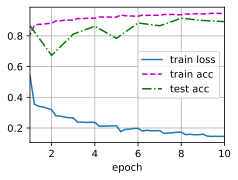

In [16]:
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)